In [10]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


In [11]:
df_main = pd.read_csv('../data/cleaned_main.csv')
# exporting for future models 
train_whole = pd.read_csv('../data/train_test_whole_dfs/train_whole.csv')
y3_train = pd.read_csv('../data/train_test_whole_dfs/y_train.csv').reset_index(drop=True)
test_whole = pd.read_csv('../data/train_test_whole_dfs/test_whole.csv')
y3_test = pd.read_csv('../data/train_test_whole_dfs/y_test.csv').reset_index(drop=True)
df_main.head()

,selftext,title,target
0,There are a lot of chauvinists in the U S who ...,Is Kamala Harris more at risk of assassination...,0
1,Let me explain The name of your movement shoul...,A push labeled Let mothers hold their babies,0
2,I have read about some horrific pit bull attac...,Why don t we see politicians supporting pit bu...,0
3,Some international observers have argued that ...,What threat does EU expansion pose towards Russia,0
4,Every definition of the term implies cheating ...,Why is gerrymandering legal,0


In [12]:
print('train whole shape: ',train_whole.shape,y3_train.shape)
print('test whole shape: ',test_whole.shape, y3_test.shape)
# # should return the following
# train whole shape:  (1485, 3005) (1485,)
# test whole shape:  (496, 3005) (496,)

train whole shape:  (1485, 3005) (1485, 1)
test whole shape:  (496, 3005) (496, 1)


In [13]:
# sanity check that this is still representative of a train_test_split 
print(y3_train.value_counts(normalize=True))
y3_test.value_counts(normalize=True)

target
0         0.50303
1         0.49697
dtype: float64


target
0         0.504032
1         0.495968
dtype: float64

In [25]:
# quickly confirming these are acceptable to be dropped
print(df_main.isnull().sum())
df_main[df_main['selftext'].isnull()]

selftext    19
title        0
target       0
dtype: int64


,selftext,title,target
6,NaN,Serious What would happen if after the war in ...,0
233,NaN,if u are a capitalist why are u not a communis...,0
925,NaN,When and how did India help the USA during the...,0
1000,NaN,WEF looking to Memory Hole large parts of the ...,1
1034,NaN,I found another video of the Americans in Ukraine,1
1259,NaN,Watch my New video on TikTok about Military Se...,1
1273,NaN,U S Mercenaries are in Ukraine fighting Russia...,1
1325,NaN,A study led by scientists from the Arctic Univ...,1
1327,NaN,The Jesuits have a supremacy over the Intellig...,1
1330,NaN,A study led by scientists from the Arctic Univ...,1


In [26]:
# checking to make sure posts that only had a title are removed to establish correct baseline
print(df_main['selftext'].isnull().sum())
df_main.dropna(inplace=True) # random empty selftext or titles
print(df_main['selftext'].isnull().sum())

19
0


In [29]:
# baseline accuracy (what we want to perform better)
df_main['target'].value_counts(normalize=True)[0]

0.5032811711256941

Because of the careful cleaning we have a evenly split dataset that we want to perform better than just having a 50% chance of guessing whether a post is from the Conspiracy subreddit versus AskPolitics subreddit.

---
Best log classifier model below (refresher)

best score 1.0
best params {'model__penalty': 'none', 'model__solver': 'newton-cg'}
train score 1.0
test score 1.0


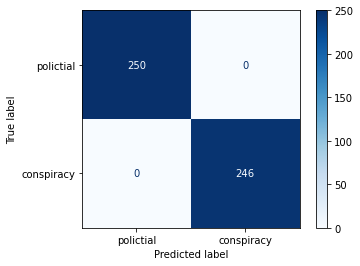

In [25]:
# best results from linear regression
pipe  = Pipeline([ ('model', LogisticRegression(max_iter=10_000)) ])

# running with same inital pipe for Logistic Reg model (pipe)
hyper_params = {
    'model__penalty':['none'], # 
    'model__solver':['newton-cg'] # 
}

gs_whole2 = GridSearchCV(pipe, hyper_params,cv=3)
gs_whole2.fit(train_whole,y3_train['target'])

print('best score',gs_whole2.best_score_) # best cross validated score (defualt logistic regression - accuracy)
print('best params',gs_whole2.best_params_)
print('train score',gs_whole2.score(train_whole,y3_train['target']))
print('test score',gs_whole2.score(test_whole,y3_test['target']))


plot_confusion_matrix(gs_whole2,test_whole,y3_test,cmap='Blues',display_labels=['polictial','conspiracy']);

best log classification model above 
___

--- 
Model Random Forest

In [38]:

# these are the actual observations that contained target within the selftext or title 
train_whole[train_whole['target']>=1]['target']

576     1
667     1
830     1
940     1
975     1
1226    1
1257    1
1322    1
Name: target, dtype: int64

In [51]:
# have to ensure that only the 
y3_train = y3_train['target']
y3_test = y3_test['target']
rf = RandomForestClassifier(n_estimators=100)  # only creating 100 decision tree
print('cross val score',cross_val_score(rf, train_whole, y3_train, cv = 5).mean())
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth':[None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid = rf_params,
                 cv = 5, n_jobs = -1)

gs.fit(train_whole, y3_train)
print(gs.best_score_)
gs.best_params_
print('training score: ',gs.score(train_whole,y3_train))
print('testing score:',gs.score(test_whole,y3_test))

cross val score 1.0
1.0
training score:  1.0
test score:  1.0


In [77]:
# RANDOM FOREST ON ORIGINAL DATASET WITHOUT (UPPER/LOWER CASE COUNT OR PUNCTUATION COUNT )
X = df_main.drop(columns=['target'])
y = df_main['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

# instantiate a vectorizer with parameters from grid search used to create (whole train/test dataframes in model above)
cvec = CountVectorizer(stop_words='english', # eliminating the basic stop words
                       binary=True,
                       lowercase =False, # we want to pay attention to case sensitivity later
                        max_df= 0.75, # this is a form of creating a customized stop words list 
                        max_features= 3000,ngram_range=(1,1) ) 

# fit and transform on self text
Xv_train = cvec.fit_transform(X_train['selftext'])
Xv_test = cvec.transform(X_test['selftext'])

# Convert X_train and X_test into a DataFrame.
Xv_train_rf = pd.DataFrame(Xv_train.todense(),columns=cvec.get_feature_names())
Xv_test_rf = pd.DataFrame(Xv_test.todense(),columns=cvec.get_feature_names())

# initializing random forest model + grid search params
rf = RandomForestClassifier(n_estimators=100)  # only creating 100 decision tree
print('cross val score: ',cross_val_score(rf, Xv_train_rf, y_train, cv = 5).mean())
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth':[None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid = rf_params,
                 cv = 5, n_jobs = -1)
# fitting to training data/outputing model evaluation
gs.fit(Xv_train_rf, y_train)
print('best score: ',gs.best_score_)
print('best params: ',gs.best_params_)
print('This is the baseline we want to perform better than',y.value_counts(normalize=True)[0])
print('training score: ',gs.score(Xv_train_rf,y_train))
print('test score: ',gs.score(Xv_test_rf,y_test))

cross val score:  0.7542087542087541
best score:  0.7548821548821549
best params:  {'max_depth': None, 'n_estimators': 150}
This is the baseline we want to perform better than 0.5032811711256941
training score:  0.997979797979798
test score:  0.8004032258064516
